In [56]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
# from tabulate import tabulate

import os, shutil, time, pdb, random
import scipy.stats as stats 
import scipy

from math import pi
from datetime import datetime
from collections import OrderedDict
import pickle

import torch
from torch.utils.data import TensorDataset, DataLoader

from importlib import reload
from models import *
from utils import *
from runmanager import *
from experiment import *
from plot_utils import *
from preprocessing_utils import *
from seasonal_analysis import * 

from sklearn.metrics import mean_squared_error as mse

import matplotlib
matplotlib.rc_file_defaults()
%matplotlib inline


pd.options.display.max_columns = None

np.random.seed(4)

%load_ext autoreload
%autoreload 2

# Detect device.
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import data

In [57]:
# Parameters
start="1995-01-01"
end="2015-12-31"

# TRAIN_PATH = "../data/pickle/df_stations_all_nonzero_extended.pkl"
# TEST_PATH = "../data/pickle/df_stations_val_all_nonzero_extended.pkl"

TRAIN_PATH = '../../data/norris/enriched_obs/enriched_wapda_obs_norris.pkl'

In [58]:
# st = create_station_dataframe(TRAIN_PATH, start, end, add_yesterday=True, basin_filter = None, filter_incomplete_years = True)

data = DataPreprocessing(train_path=TRAIN_PATH, start=start, end=end, 
                add_yesterday = False, 
                basin_filter = None, 
                split_bias_corrected_only = False, 
                filter_incomplete_years = False, 
                include_non_bc_stations = True, 
                split_by = 'station')

77068


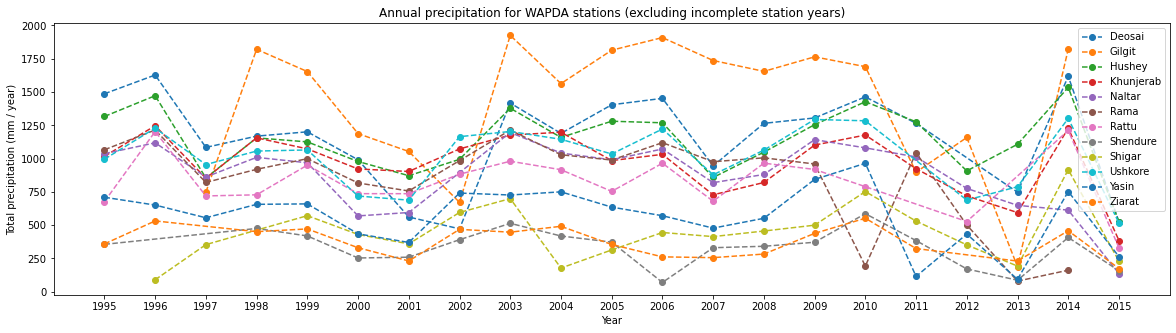

In [59]:
print(len(data.st))
df = data.st.groupby(["Station","year"]).sum()['precip_norris'].reset_index()
plt.figure(figsize=(20,5))
for s in df.Station.unique():
    df_s = df[df["Station"]==s].reset_index()[['year','precip_norris']].sort_values('year')
    x = df_s['year']
    y = df_s['precip_norris']
    plt.plot(x,y,'--o',label=s)
plt.legend()
plt.ylabel('Total precipitation (mm / year)')
plt.xlabel('Year')
plt.xticks(sorted(df.year.unique()))
plt.title('Annual precipitation for WAPDA stations (excluding incomplete station years)')
plt.show()

In [60]:
data.split_stations()

In [61]:
# data.st.rename(columns={'Longitude':'X','Latitude':'Y','Elevation':'Z'}, inplace=True)
data.st.rename(columns={'Lon':'X','Lat':'Y'}, inplace=True)

In [62]:
data.st['doy'] = data.st['Date'].dt.dayofyear

In [63]:
data.st['doy_sin'] = data.st['doy'].transform(lambda x: np.sin(x))
data.st['doy_cos'] = data.st['doy'].transform(lambda x: np.cos(x))

In [64]:
data.st.Prec = data.st.Prec.astype('float64')

ValueError: could not convert string to float: 'S'

### Split data into held out sets for K-fold cross validation

### Prepare data

In [23]:
predictors = [
                'wrf_prcp',
                'wrf_prcp_-2','wrf_prcp_-1','wrf_prcp_1','wrf_prcp_2',
                'Z',
                #'doy',
                'doy_sin',
                'doy_cos',
                'X',
                'Y',
                'aspect',
                'slope',
                'year',
                'era5_u','era5_u_-1','era5_u_-2','era5_u_1','era5_u_2',
                'era5_v','era5_v_-1','era5_v_-2','era5_v_1','era5_v_2',
             ]

doy = ['doy_sin', 'doy_cos']
dem = ['Z','slope','aspect']
xy = ['X','Y']
year = ['year']
cwv = ['CWV_norris']
rh = ['RH2_norris', 'RH500_norris']
temp = ['T2_norris', 'T2max_norris', 'T2min_norris', 'Td2_norris']
prec = ['precip_norris', 'rain_norris']
wind = ['u10_norris', 'u500_norris', 'v10_norris', 'v500_norris']

predictors = [ 
                'doy_sin',
                'doy_cos',
                'Z',
                'X',
                'Y',
                #'aspect',
                #'slope',
                'year',
                'CWV_norris', 
                'RH2_norris', 'RH500_norris', 
                'T2_norris', 'T2max_norris', 'T2min_norris', 'Td2_norris', 
                'precip_norris', 'rain_norris', 
                'u10_norris', 'u500_norris', 'v10_norris', 'v500_norris',
              ]

# predictors.append('obs_yesterday')

predictand = ['Prec']

data.input_data(predictors, predictand, sort_by_quantile=False)

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

## Multi-Run: Train model with different hyperparameters

### Model run

In [21]:
params = OrderedDict(
    lr = [0.005]
    ,batch_size = [128]
    ,likelihood_fn = ['bgmm', 'b2gmm'] #['bernoulli_loggaussian','gamma']
    ,hidden_channels = [[50,50]] #[[10], [50], [100], [50,50], [100,100]] #[[10],[30],[50],[100],[10,10],[30,30],[50,50],[100,100]]
    ,dropout_rate = [0]
    ,linear_model = [False, True] #['True','False']
    #,k = [0]
    ,k = list(range(10))
)

epochs = 20

n = 1 
for k,v in params.items():
    n = len(v) * n
print('# models:', n)
print('# epochs:', n*epochs)

# models: 40
# epochs: 800


In [22]:
st_test, predictions = multirun(data, predictors, params, epochs, split_by='station',
                                sequential_samples=False)

NameError: name 'predictors' is not defined

In [13]:
for run in predictions.keys():
    for i in range(len(params['k'])):
        predictions[run][f'k{i}']['k_fold'] = i
        if i == 0:
            predictions[run]['k_all'] = predictions[run][f'k{i}']
        else:
            predictions[run]['k_all'] = pd.concat([predictions[run]['k_all'],predictions[run][f'k{i}']])

In [14]:
# Table of predictions
seasons = ['Winter (JFM)', 'Premonsoon (AM)', 'Monsoon (JJAS)','Postmonsoon (OND)']
# seasons = ['JFM', ' AM', ' JJAS',' OND']
# table_of_predictions(predictions, seasons, sample_cols=['sample'])

In [15]:
# for key in predictions.keys():
#     predictions[key]['k_all'].rename(columns={"sample": "sample_0"}, inplace=True)

In [16]:
# predictions['bgmm_[50]_False']['k_all'].rename(columns={"wrf_prcp": "bannister_wrf_prcp", "precip_norris": "wrf_prcp"}, inplace=True)

In [17]:
n_samples = 10
sample_cols = [f'sample_{i}' for i in range(n_samples)]
add_cols = []

columns = ['Prec','wrf_prcp','wrf_bc_prcp','precip_norris'] #+ sample_cols + add_cols

In [18]:
for p in predictions.keys(): 
    for k,v in predictions[p].items():
        v['wrf_prcp'] = v['precip_norris'] 
        v['wrf_bc_prcp'] = v['precip_norris'] 

In [19]:
predictions.keys()

dict_keys(['bgmm_[50, 50]_NL_B=128_D=0', 'bgmm_[50, 50]_L_B=128_D=0', 'b2gmm_[50, 50]_NL_B=128_D=0', 'b2gmm_[50, 50]_L_B=128_D=0'])

In [20]:
for k,v in predictions.items():
    print(k, ':\t', v['k_all'].BS.mean())

bgmm_[50, 50]_NL_B=128_D=0 :	 0.4628591230648159
bgmm_[50, 50]_L_B=128_D=0 :	 0.42561195835549576
b2gmm_[50, 50]_NL_B=128_D=0 :	 0.48150217182898936
b2gmm_[50, 50]_L_B=128_D=0 :	 0.4115486764704316


In [21]:
for k,v in predictions.items():
    print(k, ':\t', v['k_all'].QS.mean())

bgmm_[50, 50]_NL_B=128_D=0 :	 0.856476760422372
bgmm_[50, 50]_L_B=128_D=0 :	 0.8391866680249762
b2gmm_[50, 50]_NL_B=128_D=0 :	 2.4252992483824536
b2gmm_[50, 50]_L_B=128_D=0 :	 0.8264298364076698


In [22]:
table_of_predictions_ks_test(predictions, seasons, columns, sample_cols, add_cols)

bgmm_[50, 50]_NL_B=128_D=0
bgmm_[50, 50]_L_B=128_D=0
b2gmm_[50, 50]_NL_B=128_D=0
b2gmm_[50, 50]_L_B=128_D=0
Model                        Winter (JFM) mean    Winter (JFM) median    Premonsoon (AM) mean    Premonsoon (AM) median    Monsoon (JJAS) mean    Monsoon (JJAS) median    Postmonsoon (OND) mean    Postmonsoon (OND) median
---------------------------  -------------------  ---------------------  ----------------------  ------------------------  ---------------------  -----------------------  ------------------------  --------------------------
Bann                         0.1971               0.1144                 0.1891                  0.1079                    0.1345                 0.0943                   0.1058                    0.1159
BannCorr                     0.1971               0.1144                 0.1891                  0.1079                    0.1345                 0.0943                   0.1058                    0.1159
Norr                         0.1971   

In [23]:
table_of_predictions_for_metric(predictions, seasons, columns, n_samples, sample_cols, add_cols, metric = 'smape', prefix='smape')

Model                        Winter (JFM) mean    Winter (JFM) median    Premonsoon (AM) mean    Premonsoon (AM) median    Monsoon (JJAS) mean    Monsoon (JJAS) median    Postmonsoon (OND) mean    Postmonsoon (OND) median
---------------------------  -------------------  ---------------------  ----------------------  ------------------------  ---------------------  -----------------------  ------------------------  --------------------------
Bann                         0.58                 0.63                   0.50                    0.55                      0.46                   0.45                     0.46                      0.48
BannCorr                     0.58                 0.63                   0.50                    0.55                      0.46                   0.45                     0.46                      0.48
Norr                         0.58                 0.63                   0.50                    0.55                      0.46                   0.45

In [24]:
table_of_predictions_for_metric(predictions, seasons, columns, n_samples, sample_cols, add_cols, metric = 'edd', prefix='edd')

Model                        Winter (JFM) mean    Winter (JFM) median    Premonsoon (AM) mean    Premonsoon (AM) median    Monsoon (JJAS) mean    Monsoon (JJAS) median    Postmonsoon (OND) mean    Postmonsoon (OND) median
---------------------------  -------------------  ---------------------  ----------------------  ------------------------  ---------------------  -----------------------  ------------------------  --------------------------
Bann                         34.71                36.00                  22.16                   21.00                     36.96                  39.00                    14.64                     11.00
BannCorr                     34.71                36.00                  22.16                   21.00                     36.96                  39.00                    14.64                     11.00
Norr                         34.71                36.00                  22.16                   21.00                     36.96                  39

In [25]:
table_of_predictions_for_metric(predictions, seasons, columns, n_samples, sample_cols, add_cols, metric = 'ae', prefix='ae')

Model                        Winter (JFM) mean    Winter (JFM) median    Premonsoon (AM) mean    Premonsoon (AM) median    Monsoon (JJAS) mean    Monsoon (JJAS) median    Postmonsoon (OND) mean    Postmonsoon (OND) median
---------------------------  -------------------  ---------------------  ----------------------  ------------------------  ---------------------  -----------------------  ------------------------  --------------------------
Bann                         327.38               302.25                 141.29                  125.09                    246.04                 220.04                   101.63                    82.44
BannCorr                     327.38               302.25                 141.29                  125.09                    246.04                 220.04                   101.63                    82.44
Norr                         327.38               302.25                 141.29                  125.09                    246.04                 22

In [26]:
table_of_predictions_for_metric(predictions, seasons, columns, n_samples, sample_cols, add_cols, metric = 'se', prefix='se')

Model                        Winter (JFM) mean    Winter (JFM) median    Premonsoon (AM) mean    Premonsoon (AM) median    Monsoon (JJAS) mean    Monsoon (JJAS) median    Postmonsoon (OND) mean    Postmonsoon (OND) median
---------------------------  -------------------  ---------------------  ----------------------  ------------------------  ---------------------  -----------------------  ------------------------  --------------------------
Bann                         156422.62            91356.02               30075.83                15647.17                  95476.13               48416.52                 17236.11                  6796.64
BannCorr                     156422.62            91356.02               30075.83                15647.17                  95476.13               48416.52                 17236.11                  6796.64
Norr                         156422.62            91356.02               30075.83                15647.17                  95476.13             

In [28]:
a = pd.read_csv('results.csv')

b = a.groupby(['k','run']).agg({'valid_loss': 'min', 
                                 'hidden_channels': 'first', 
                                 'likelihood_fn': 'first',
                                 'lr':'first',
                                 'batch_size':'first',
                                 'dropout_rate':'first',
                                 'linear_model':'first'})

c = b.groupby(['run']).agg({'valid_loss': 'mean', 
                        'hidden_channels': 'first', 
                        'likelihood_fn': 'first',
                        'lr':'first',
                        'batch_size':'first',
                        'dropout_rate':'first',
                         'linear_model':'first'}
                   ).sort_values('valid_loss').reset_index()

d = c.groupby(['hidden_channels',
           'likelihood_fn',
           'lr',
           'batch_size',
           'dropout_rate',
           'linear_model']).agg({'valid_loss': 'mean'}
                   ).sort_values('valid_loss').reset_index()

In [29]:
d

,hidden_channels,likelihood_fn,lr,batch_size,dropout_rate,linear_model,valid_loss
0,"[50, 50]",b2gmm,0.005,128,0,False,0.950474
1,"[50, 50]",b2gmm,0.005,128,0,True,1.046141
2,"[50, 50]",bgmm,0.005,128,0,False,1.063186
3,"[50, 50]",bgmm,0.005,128,0,True,1.072198


In [31]:
c

,run,valid_loss,hidden_channels,likelihood_fn,lr,batch_size,dropout_rate,linear_model
0,21,0.866799,"[50, 50]",b2gmm,0.005,128,0,False
1,28,0.869858,"[50, 50]",b2gmm,0.005,128,0,False
2,23,0.871032,"[50, 50]",b2gmm,0.005,128,0,False
3,26,0.883645,"[50, 50]",b2gmm,0.005,128,0,False
4,27,0.885821,"[50, 50]",b2gmm,0.005,128,0,False
5,22,0.888385,"[50, 50]",b2gmm,0.005,128,0,False
6,30,0.896452,"[50, 50]",b2gmm,0.005,128,0,False
7,25,0.926719,"[50, 50]",b2gmm,0.005,128,0,False
8,40,0.970399,"[50, 50]",b2gmm,0.005,128,0,True
9,31,0.970613,"[50, 50]",b2gmm,0.005,128,0,True
